In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Dados

In [60]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSr7tU5tK8cvvR32yypE1PArgXhmNbFJ9bw8w6Sm2zQhyaMs27csoo-77vgFedHw9z25Ez3Qm-geKyU/pub?gid=43084471&single=true&output=csv', skiprows= 1)

df.drop(columns='Unnamed: 0', inplace= True)
df.reset_index(drop = True)
df

,Parameter,MTOW,Empty_Weight,Payload_Weight,Number_of_passengers,Baggage_compartment_volume,Range,Cruise_Mach,Cruise_altitude,Service_ceiling,...,Number_of_window_exits,Number_of_engines,Engine_location,Total_maximum_thrust,Engine_TSFC,Wing_loading,Thrust-to-weight_ratio,Landing_gear_configuration,Number_of_wheels_of_the_NLG,Number_of_wheels_of_the_MLG
0,E175,"73,000.00","41,000.00","20,000.00",150.0,40.0,"4,500.00",0.78,"12,000.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A220,"85,000.00","48,000.00","25,000.00",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A320,"90,000.00","52,000.00","26,000.00",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A737,"65,000.00","38,000.00","16,000.00",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Função para fazer os plots

In [109]:
def plotar(coluna1, coluna2):

    df[coluna1] = df[coluna1].astype(str).str.replace(',', '').str.strip()
    df[coluna2] = df[coluna2].astype(str).str.replace(',', '').str.strip()

    # Converter para float
    df[coluna1] = pd.to_numeric(df[coluna1], errors='coerce')
    df[coluna2] = pd.to_numeric(df[coluna2], errors='coerce')

    X = df[coluna1].values
    Y = df[coluna2].values
    
    # Ajuste polinomial de grau 1 (reta)
    Z = np.polyfit(X, Y, 1)
    p = np.poly1d(Z)
    
    # Predição de valores
    Y_pred = p(X)
    delta_x = (X.max() - X.min()) / 60
    delta_y = (Y.max() - Y.min()) / 25
    
    # Criar DataFrame de saída
    df_aviao = df[['Parameter', coluna1, coluna2]].copy()
    df_aviao['Y_pred'] = Y_pred
    df_aviao.set_index('Parameter', inplace= True)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X, Y, label='Dados Históricos', color = 'black')

    sns.set_theme(style="white")
    sns.lineplot(x=np.sort(X), y=np.sort(Y_pred), color='gray', linestyle='dashed', label='Regressão')
    
    for index, aviao in df_aviao.iterrows():
        x = aviao[coluna1]
        y = aviao[coluna2]
        y_pred = aviao['Y_pred']
        label_x = x - delta_x
        label_y = y + delta_y*0.5 if y > y_pred else y - delta_y
        plt.text(label_x, label_y, str(index), fontsize=10)

    plt.xlabel(coluna1, fontsize=16)
    plt.ylabel(coluna2, fontsize=16)
    plt.legend(fontsize = 14)
    
    ax = plt.gca()

    # Remove os traços do eixo superior e direito
    ax.tick_params(axis='x', top=False)
    ax.tick_params(axis='y', right=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.6)
    ax.spines['left'].set_linewidth(0.6)

    # Mantém os traços nos eixos inferior e esquerdo
    ax.tick_params(axis='x', bottom=True, direction='in', length=4, width=0.6)
    ax.tick_params(axis='y', left=True, direction='in', length=4, width=0.6)
    plt.grid(False)
    plt.show()


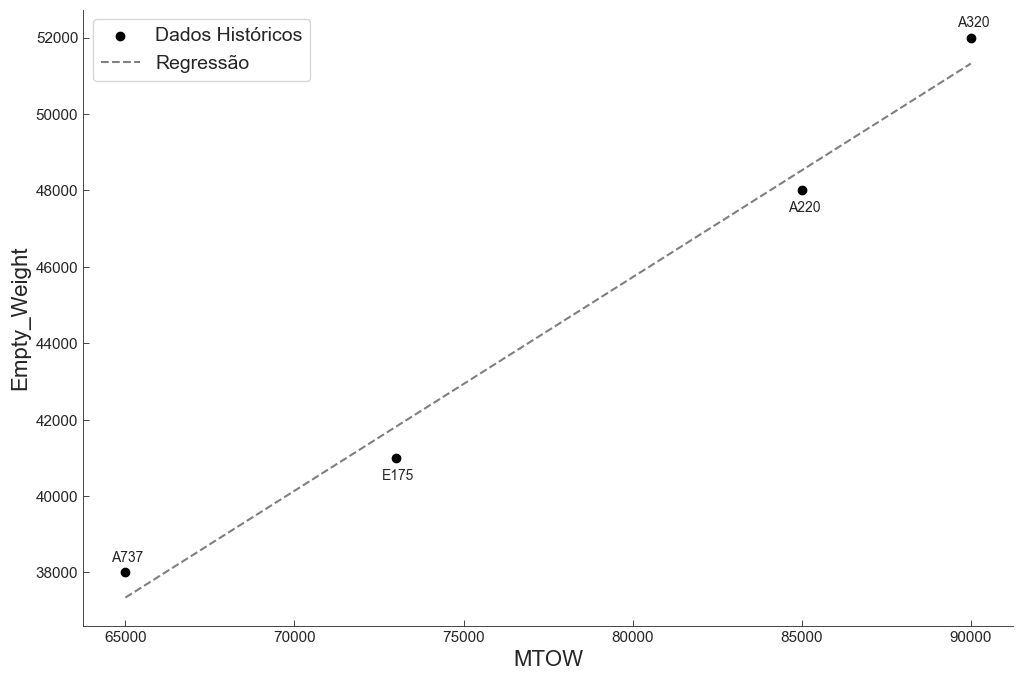

In [110]:
# Peso Vazio x MTOW

plotar("MTOW", "Empty_Weight")


In [ ]:
# Número de passageiros x MTOW

In [ ]:
# Número de passageiros x Comprimento de fuselagem